# Lecture 1

In [1]:
import numpy as np
import numba
from scipy import optimize
import matplotlib.pyplot as plt

# some useful plot defaults
plt.rcParams.update({'font.size' : 20, 'lines.linewidth' : 3.5, 'figure.figsize' : (13,7)})

In [2]:
def discretize_assets(amin, amax, n_a):
    # find maximum ubar of uniform grid corresponding to desired maximum amax of asset grid
    ubar = np.log(1 + np.log(1 + amax - amin))
    
    # make uniform grid
    u_grid = np.linspace(0, ubar, n_a)
    
    # double-exponentiate uniform grid and add amin to get grid from amin to amax
    return amin + np.exp(np.exp(u_grid) - 1) - 1

In [3]:
a_grid = discretize_assets(0, 10_000, 50)
with np.printoptions(precision=2):
    print(a_grid)

[0.00e+00 4.98e-02 1.05e-01 1.65e-01 2.32e-01 3.07e-01 3.90e-01 4.82e-01
 5.86e-01 7.03e-01 8.34e-01 9.83e-01 1.15e+00 1.34e+00 1.57e+00 1.82e+00
 2.11e+00 2.45e+00 2.85e+00 3.31e+00 3.86e+00 4.51e+00 5.29e+00 6.21e+00
 7.34e+00 8.70e+00 1.04e+01 1.24e+01 1.50e+01 1.82e+01 2.23e+01 2.75e+01
 3.42e+01 4.29e+01 5.43e+01 6.96e+01 9.01e+01 1.18e+02 1.57e+02 2.11e+02
 2.87e+02 3.97e+02 5.58e+02 7.97e+02 1.16e+03 1.71e+03 2.58e+03 3.97e+03
 6.23e+03 1.00e+04]


In [4]:
def rouwenhorst_Pi(N, p):
    # base case Pi_2
    Pi = np.array([[p, 1 - p],
                   [1 - p, p]])
    
    # recursion to build up from Pi_2 to Pi_N
    for n in range(3, N + 1):
        Pi_old = Pi
        Pi = np.zeros((n, n))
        
        Pi[:-1, :-1] += p * Pi_old
        Pi[:-1, 1:] += (1 - p) * Pi_old
        Pi[1:, :-1] += (1 - p) * Pi_old
        Pi[1:, 1:] += p * Pi_old
        Pi[1:-1, :] /= 2
        
    return Pi

In [5]:
def stationary_markov(Pi, tol=1E-14):
    # start with uniform distribution over all states
    n = Pi.shape[0]
    pi = np.full(n, 1/n)
    
    # update distribution using Pi until successive iterations differ by less than tol
    for _ in range(10_000):
        pi_new = Pi.T @ pi
        if np.max(np.abs(pi_new - pi)) < tol:
            return pi_new
        pi = pi_new

In [6]:
def discretize_income(rho, sigma, n_s):
    # choose inner-switching probability p to match persistence rho
    p = (1+rho)/2
    
    # start with states from 0 to n_s-1, scale by alpha to match standard deviation sigma
    s = np.arange(n_s)
    alpha = 2*sigma/np.sqrt(n_s-1)
    s = alpha*s
    
    # obtain Markov transition matrix Pi and its stationary distribution
    Pi = rouwenhorst_Pi(n_s, p)
    pi = stationary_markov(Pi)
    
    # s is log income, get income y and scale so that mean is 1
    y = np.exp(s)
    y /= np.vdot(pi, y)
    
    return y, pi, Pi

In [7]:
y, pi, Pi = discretize_income(0.975, 0.7, 7)
y, pi

(array([0.1413694 , 0.25036602, 0.44339966, 0.78526334, 1.3907059 ,
        2.46294815, 4.36189534]),
 array([0.015625, 0.09375 , 0.234375, 0.3125  , 0.234375, 0.09375 ,
        0.015625]))

In [8]:
np.vdot(pi, y)

1.0

In [9]:
def backward_iteration(Va, Pi, a_grid, y, r, beta, eis):
    # step 1: discounting and expectations
    Wa = (beta * Pi) @ Va
    
    # step 2: solving for asset policy using the first-order condition
    c_endog = Wa**(-eis)
    coh = y[:, np.newaxis] + (1+r)*a_grid
    
    a = np.empty_like(coh)
    for s in range(len(y)):
        a[s, :] = np.interp(coh[s, :], c_endog[s, :] + a_grid, a_grid)
        
    # step 3: enforcing the borrowing constraint and backing out consumption
    a = np.maximum(a, a_grid[0])
    c = coh - a
    
    # step 4: using the envelope condition to recover the derivative of the value function
    Va = (1+r) * c**(-1/eis)
    
    return Va, a, c

In [10]:
def policy_ss(Pi, a_grid, y, r, beta, eis, tol=1E-9):
    # initial guess for Va: assume consumption 5% of cash-on-hand, then get Va from envelope condition
    coh = y[:, np.newaxis] + (1+r)*a_grid
    c = 0.05*coh
    Va = (1+r) * c**(-1/eis)
    
    # iterate until maximum distance between two iterations falls below tol, fail-safe max of 10,000 iterations
    for it in range(10_000):
        Va, a, c = backward_iteration(Va, Pi, a_grid, y, r, beta, eis)
        
        # after iteration 0, can compare new policy function to old one
        if it > 0 and np.max(np.abs(a - a_old)) < tol:
            return Va, a, c
        
        a_old = a

In [11]:
a_grid = discretize_assets(0, 10_000, 500)
y, pi, Pi = discretize_income(0.975, 0.7, 7)
r = 0.01/4
beta = 1-0.08/4
eis = 1

In [12]:
Pi

array([[9.27305052e-01, 7.04282318e-02, 2.22874151e-03, 3.76158905e-05,
        3.57112885e-07, 1.80816650e-09, 3.81469727e-12],
       [1.17380386e-02, 9.28047966e-01, 5.87090011e-02, 1.48606575e-03,
        1.88094521e-05, 1.19041443e-07, 3.01361084e-10],
       [1.48582767e-04, 2.34836004e-02, 9.28493857e-01, 4.69747253e-02,
        8.91687069e-04, 7.52378082e-06, 2.38075256e-08],
       [1.88079453e-06, 4.45819725e-04, 3.52310439e-02, 9.28642511e-01,
        3.52310439e-02, 4.45819725e-04, 1.88079453e-06],
       [2.38075256e-08, 7.52378082e-06, 8.91687069e-04, 4.69747253e-02,
        9.28493857e-01, 2.34836004e-02, 1.48582767e-04],
       [3.01361084e-10, 1.19041443e-07, 1.88094521e-05, 1.48606575e-03,
        5.87090011e-02, 9.28047966e-01, 1.17380386e-02],
       [3.81469727e-12, 1.80816650e-09, 3.57112885e-07, 3.76158905e-05,
        2.22874151e-03, 7.04282318e-02, 9.27305052e-01]])

In [13]:
Va, a, c = policy_ss(Pi, a_grid, y, r, beta, eis)

In [14]:
Va[2,66]

1.8713825357966836

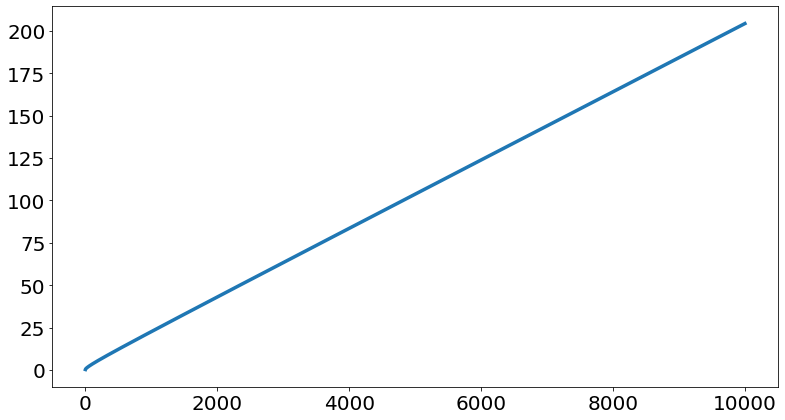

In [15]:
plt.plot(a_grid, c[1,:])

In [16]:
mpcs = np.empty_like(c)
    
# symmetric differences away from boundaries
mpcs[:, 1:-1] = (c[:, 2:] - c[:, 0:-2]) / (a_grid[2:] - a_grid[:-2]) / (1+r)

# asymmetric first differences at boundaries
mpcs[:, 0]  = (c[:, 1] - c[:, 0]) / (a_grid[1] - a_grid[0]) / (1+r)
mpcs[:, -1] = (c[:, -1] - c[:, -2]) / (a_grid[-1] - a_grid[-2]) / (1+r)

# special case of constrained
mpcs[a == a_grid[0]] = 1

In [17]:
def get_lottery(a, a_grid):
    # step 1: find the i such that a' lies between gridpoints a_i and a_(i+1)
    a_i = np.searchsorted(a_grid, a) - 1
    
    # step 2: obtain lottery probabilities pi
    a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])
    
    return a_i, a_pi

In [18]:
a_i, a_pi = get_lottery(a, a_grid)
a_i.shape, a_i.dtype, a_pi.shape, a_pi.dtype

((7, 500), dtype('int64'), (7, 500), dtype('float64'))

In [19]:
@numba.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for s in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(s,a) of the mass to gridpoint i(s,a)
            Dend[s, a_i[s,a]] += a_pi[s,a]*D[s,a]
            
            # send 1-pi(s,a) of the mass to gridpoint i(s,a)+1
            Dend[s, a_i[s,a]+1] += (1-a_pi[s,a])*D[s,a]
            
    return Dend

In [20]:
def forward_iteration(D, Pi, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return Pi.T @ Dend

In [21]:
def distribution_ss(Pi, a, a_grid, tol=1E-10):
    a_i, a_pi = get_lottery(a, a_grid)
    
    # as initial D, use stationary distribution for s, plus uniform over a
    pi = stationary_markov(Pi)
    D = pi[:, np.newaxis] * np.ones_like(a_grid) / len(a_grid)
    
    # now iterate until convergence to acceptable threshold
    for _ in range(10_000):
        D_new = forward_iteration(D, Pi, a_i, a_pi)
        if np.max(np.abs(D_new - D)) < tol:
            return D_new
        D = D_new

In [22]:
D = distribution_ss(Pi, a, a_grid)
D[6,490:500]

array([5.33914237e-114, 2.94148691e-115, 1.44236406e-116, 6.19666168e-118,
       2.28487726e-119, 7.03004560e-121, 1.73267679e-122, 3.20712164e-124,
       3.96280357e-126, 2.45156682e-128])

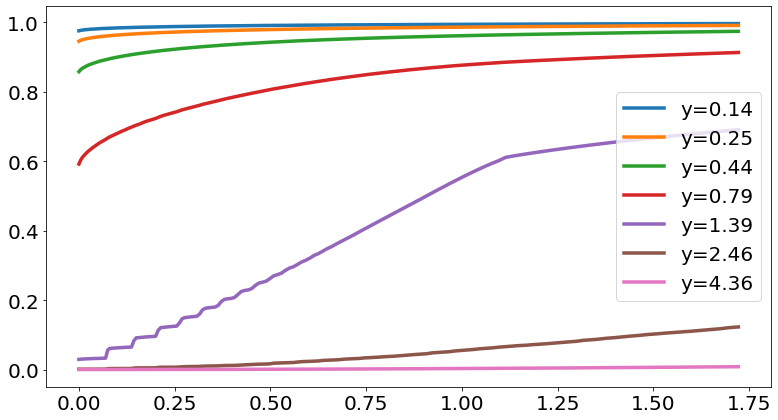

In [23]:
for s, ys in enumerate(y):
    plt.plot(a_grid[:150], D[s][:150].cumsum()/pi[s], label=f'y={ys:.2f}')
plt.legend();

In [24]:
D[1][:150].cumsum()

array([0.08867276, 0.08891896, 0.08909341, 0.08921533, 0.08932786,
       0.08943898, 0.089526  , 0.08960653, 0.08968062, 0.08975081,
       0.08982124, 0.08989139, 0.08994954, 0.09000345, 0.09005593,
       0.09010731, 0.0901622 , 0.0902152 , 0.09026206, 0.09030716,
       0.09035043, 0.09039237, 0.09043349, 0.09047399, 0.09051586,
       0.09055573, 0.09059378, 0.09063091, 0.09066703, 0.09070201,
       0.09073607, 0.09076966, 0.0908028 , 0.09083549, 0.0908677 ,
       0.09089949, 0.0909307 , 0.09096147, 0.09099143, 0.09102045,
       0.09104901, 0.09107729, 0.09110527, 0.09113297, 0.09116032,
       0.09118724, 0.09121367, 0.09123953, 0.09126496, 0.09129005,
       0.09131483, 0.09133939, 0.09136368, 0.09138778, 0.09141167,
       0.09143525, 0.09145847, 0.09148129, 0.09150376, 0.09152595,
       0.09154786, 0.09156957, 0.09159112, 0.09161247, 0.09163368,
       0.09165473, 0.09167553, 0.09169603, 0.09171618, 0.09173609,
       0.09175582, 0.09177534, 0.09179469, 0.09181393, 0.09183

In [25]:
for s, ys in enumerate(y):
    print(f'Ave assets at y={ys:.2f}: {np.vdot(a_grid, D[s, :]) / pi[s]:.2f}')

Ave assets at y=0.14: 0.02
Ave assets at y=0.25: 0.05
Ave assets at y=0.44: 0.16
Ave assets at y=0.79: 0.56
Ave assets at y=1.39: 2.19
Ave assets at y=2.46: 7.01
Ave assets at y=4.36: 17.67


In [26]:
for s, ys in enumerate(y):
    print(f'Total assets at y={ys:.2f} ({100*pi[s]:.1f}% of hh)\t: {np.vdot(a_grid, D[s, :]):.2f}')

Total assets at y=0.14 (1.6% of hh)	: 0.00
Total assets at y=0.25 (9.4% of hh)	: 0.00
Total assets at y=0.44 (23.4% of hh)	: 0.04
Total assets at y=0.79 (31.2% of hh)	: 0.17
Total assets at y=1.39 (23.4% of hh)	: 0.51
Total assets at y=2.46 (9.4% of hh)	: 0.66
Total assets at y=4.36 (1.6% of hh)	: 0.28


In [27]:
def steady_state(Pi, a_grid, y, r, beta, eis):
    Va, a, c = policy_ss(Pi, a_grid, y, r, beta, eis)
    D = distribution_ss(Pi, a, a_grid)
    
    return dict(D=D, Va=Va, 
                a=a, c=c,
                A=np.vdot(a, D), C=np.vdot(c, D), # aggregation
                Pi=Pi, a_grid=a_grid, y=y, r=r, beta=beta, eis=eis)

In [28]:
@numba.njit
def expectation_policy(Xend, a_i, a_pi):
    X = np.zeros_like(Xend)
    for s in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # expectation is pi(s,a)*Xend(s,i(s,a)) + (1-pi(s,a))*Xend(s,i(s,a)+1)
            X[s, a] = a_pi[s, a]*Xend[s, a_i[s, a]] + (1-a_pi[s, a])*Xend[s, a_i[s, a]+1]
            
    return X

In [29]:
def expectation_iteration(X, a_i, a_pi):
    Xend = Pi @ X
    return expectation_policy(Xend, a_i, a_pi)

In [30]:
def expectation_vectors(X, a_i, a_pi, T):
    # set up array of curlyEs and fill in first row with base case
    curlyE = np.empty((T, ) + X.shape)
    curlyE[0] = X
    
    # recursively apply law of iterated expectations
    for j in range(1, T):
        curlyE[j] = expectation_iteration(curlyE[j-1], a_i, a_pi)
        
    return curlyE

# Lecture 2

In [31]:
ss = steady_state(Pi, a_grid, y, r, beta, eis)

In [32]:
T = 11 # we'll calculate household responses up to T
ys = np.outer(1 + 0.01*(np.arange(T) == 5), ss['y'])

In [33]:
Va = ss['Va'] # initialize with steady-state marginal value function
a, c = [np.empty((T,) + ss['a'].shape) for _ in range(2)] # empty arrays to store a and c paths
ss_inputs = {k: ss[k] for k in ('Pi', 'a_grid', 'r', 'beta', 'eis')} # dict of non-changing ss inputs
for t in reversed(range(T)):
    Va, a[t], c[t] = backward_iteration(Va=Va, y=ys[t], **ss_inputs)

In [34]:
c_impulse = 100*(c - ss['c']) / ss['c'] 

In [35]:
D = np.empty_like(a)
D[0] = ss['D']

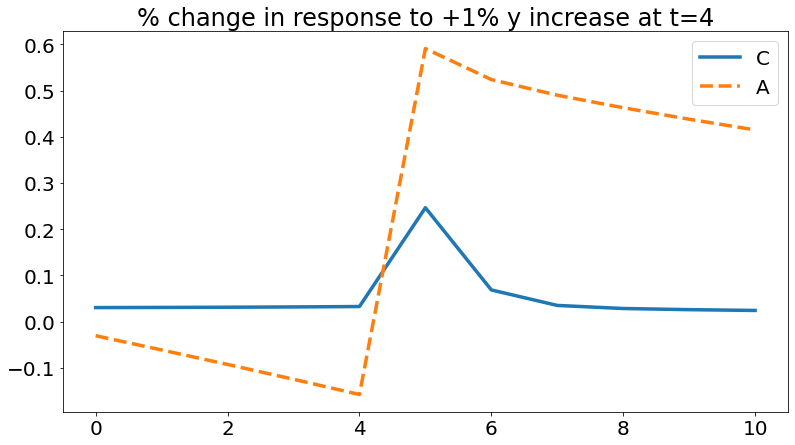

In [36]:
for t in range(T-1):
    a_i, a_pi = get_lottery(a[t], ss['a_grid'])
    
    D[t+1] = forward_iteration(D[t], ss['Pi'], a_i, a_pi)
A, C = np.empty(T), np.empty(T)
for t in range(T):
    A[t] = np.vdot(D[t], a[t])
    C[t] = np.vdot(D[t], c[t])
C_impulse = 100*(C - ss['C'])/ss['C']
A_impulse = 100*(A - ss['A'])/ss['C']
plt.plot(C_impulse, label='C')
plt.plot(A_impulse, '--', label='A')
plt.legend()
plt.title('% change in response to +1% y increase at t=4');

In [37]:
def policy_impulse(ss, shocks, T):
    # check that all values in "shocks" have first dimension T
    #assert all(x.shape[0] == T for x in shocks.values())
    
    # extract inputs to backward_iteration function from ss
    inputs = {k: ss[k] for k in ('Va', 'Pi', 'a_grid', 'y', 'r', 'beta', 'eis')}
    
    # create a T*nS*nA array to store each outputs of backward iteration
    Va, a, c  = (np.empty((T,) + ss['Va'].shape) for _ in range(3))

    for t in reversed(range(T)):
        # add this period's perturbation to parameters that are shocked
        for k in ('y', 'r', 'beta'):
            if k in shocks:
                inputs[k] = ss[k] + shocks[k][t]
                
        Va[t], a[t], c[t] = backward_iteration(**inputs)
        
        # use this Va for next iteration
        inputs['Va'] = Va[t]
        
    return Va, a, c

In [38]:
_, a_alt, c_alt = policy_impulse(ss, {'y': ys - ss['y']}, T)
assert np.array_equal(a, a_alt) and np.array_equal(c, c_alt)

In [39]:
def distribution_impulse(ss, a, T):
    assert a.shape[0] == T
    D = np.empty_like(a)
    D[0] = ss['D']
    
    for t in range(T-1):
        a_i, a_pi = get_lottery(a[t], ss['a_grid'])
        D[t+1] = forward_iteration(D[t], ss['Pi'], a_i, a_pi)
        
    return D

In [40]:
def household_impulse(ss, shocks, T):
    Va, a, c = policy_impulse(ss, shocks, T)
    D = distribution_impulse(ss, a, T)
    return dict(D=D, Va=Va, a=a, c=c, # time-varying stuff
                A=np.sum(a*D, axis=(1,2)), C=np.sum(c*D, axis=(1,2))) # aggregate everything else quickly

In [41]:
impulse = household_impulse(ss, {'y': ys - ss['y']}, T)
assert np.max(np.abs(impulse['A'] - A)) < 5E-16 and np.max(np.abs(impulse['C'] - C)) < 5E-16

In [42]:
B = 5.6
tau = ss['r']*B
e = ss['y']

beta_ge = optimize.brentq(lambda beta: steady_state(ss['Pi'], ss['a_grid'],
                                    (1-tau)*e, ss['r'], beta, ss['eis'])['A'] - B, 0.98, 0.995)
ss_ge = steady_state(ss['Pi'], ss['a_grid'], (1-tau)*e, ss['r'], beta_ge, ss['eis'])
ss_ge['A'] - B # check asset market clearing

-1.6626700016786344e-11

In [43]:
ss_ge['A']

5.599999999983373

In [44]:
T = 300
Zs = 1 + 0.01*0.95**np.arange(T)

In [45]:
pi = ss_ge['D'].sum(1) # steady-state distribution of s (unchanging)

def impulse_map(rs, Zs):
    # government budget balance at each date: tau_t = r_t*B (given average e=1) 
    taus = rs * B
    ys = np.outer(Zs - taus, e)
    
    # calculate household impulse
    impulse = household_impulse(ss_ge, {'r': rs - ss_ge['r'], 'y': ys - ss_ge['y']}, len(rs))
    
    return impulse['A'] - B, impulse

In [46]:
taus = np.full(T, ss_ge['r']) * B
ys = np.outer(Zs - taus, e)
ys[50]

array([0.139499  , 0.24705354, 0.43753324, 0.77487388, 1.3723061 ,
       2.43036199, 4.30418506])

In [47]:
taus = np.full(T, ss_ge['r']) * 5.6
ys = np.outer(1 - taus, e)
ys[50]

array([0.13939023, 0.24686089, 0.43719206, 0.77426966, 1.37123602,
       2.42846687, 4.3008288 ])

In [48]:
(Zs-taus)[0]*e[0]

0.14080392096119562

In [49]:
asset_mkt_error, impulse_z  = impulse_map(np.full(T, ss_ge['r']), Zs)

In [50]:
impulse_z['a'][50][0,0:10]

array([0.        , 0.        , 0.00166172, 0.00401945, 0.00676939,
       0.00971631, 0.01295035, 0.01632587, 0.01982096, 0.0234181 ])

In [51]:
impulse_z['D'][0][0,0:10]

array([1.31548148e-02, 7.68981807e-05, 5.66352514e-05, 3.77908196e-05,
       3.65650719e-05, 3.37362393e-05, 2.62690996e-05, 2.48750846e-05,
       2.58590462e-05, 2.36806874e-05])

In [52]:
rs = np.full(T, ss_ge['r'])
rs - ss_ge['r']
taus = rs * B
ys = np.outer(Zs - taus, e)

In [53]:
ys[0]

array([0.14080392, 0.24936455, 0.44162606, 0.78212229, 1.38514308,
       2.45309636, 4.34444776])

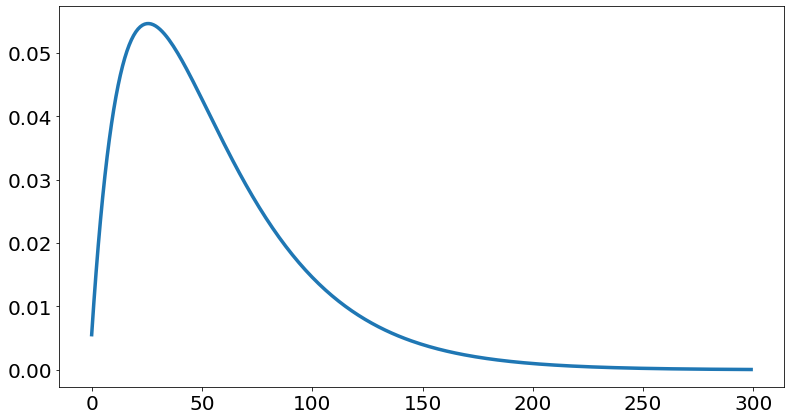

In [54]:
plt.plot(asset_mkt_error)

Converged to 0.0005 accuracy after 138 iterations


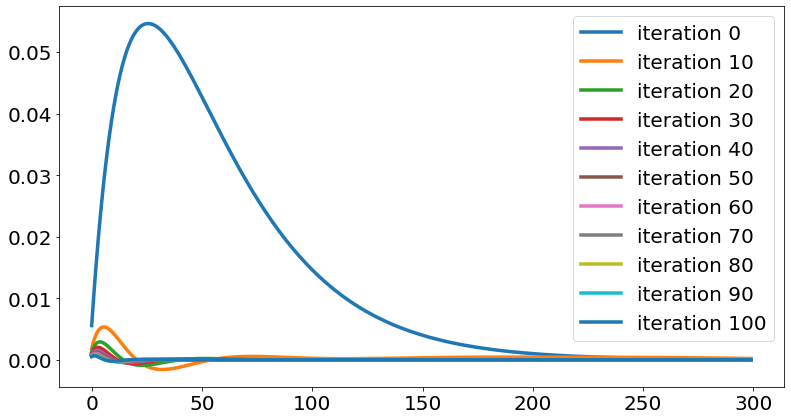

In [55]:
rs = np.full(T, ss_ge['r']) # initial guess constant
for it in range(400):
    asset_mkt_error, impulse = impulse_map(rs, Zs)
    if it % 10 == 0 and it <= 100:
        plt.plot(asset_mkt_error, label=f'iteration {it}')
    if np.max(np.abs(asset_mkt_error)) < 5E-4:
        print(f'Converged to 0.0005 accuracy after {it} iterations')
        break
    rs[1:] -= 0.002*asset_mkt_error[:-1] # remember: can't change rs[0], which was fixed here before date 0
plt.legend();

In [56]:
rs[0:11]

array([0.0025    , 0.00225225, 0.0021162 , 0.00205203, 0.00203243,
       0.00203901, 0.00205972, 0.00208692, 0.00211594, 0.00214414,
       0.00217017])

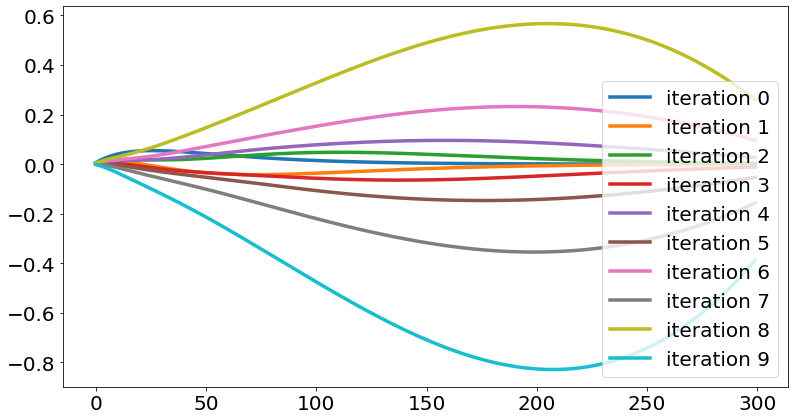

In [57]:
rs = np.full(T, ss_ge['r']) # initial guess constant
for it in range(10):
    asset_mkt_error, impulse = impulse_map(rs, Zs)
    plt.plot(asset_mkt_error, label=f'iteration {it}')
    rs[1:] -= 0.003*asset_mkt_error[:-1]
plt.legend();

In [58]:
J = np.empty((T, T))
h = 1E-4 # small shock to r is 1E-4
no_shock, no_shock_imp = impulse_map(np.full(T, ss_ge['r']), 1) # "ghost run" with no shock to subtract off
# J[i,j] is the change in impulse maps at time i to a change in the rate at time j
for tshock in range(T):
    J[:, tshock] = (impulse_map(ss_ge['r'] + h*(np.arange(T) == tshock), 1)[0] - no_shock) / h

In [59]:
J[0:10,0]

array([0.4850996 , 0.55361279, 0.61068621, 0.65901768, 0.70016684,
       0.73541059, 0.76543327, 0.79077867, 0.81194535, 0.82935877])

Asset market clearing up to 12 digits after 6 iterations


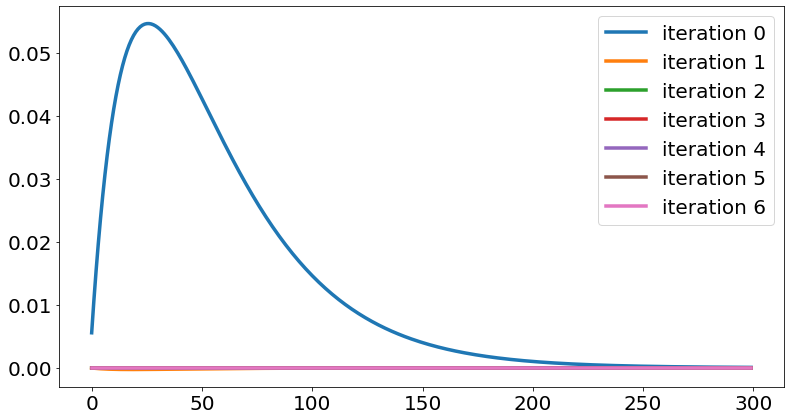

In [60]:
rs = np.full(T, ss_ge['r']) # initial guess constant
Jbar = J[:-1, 1:] # Jbar for our guesses eliminates last row and first column
errs = []
for it in range(30):
    asset_mkt_error, impulse = impulse_map(rs, Zs)
    plt.plot(asset_mkt_error, label=f'iteration {it}')
    err = np.max(np.abs(asset_mkt_error[:-1])) # solve for asset market clearing at 0, 1, ... , T-2
    errs.append(err)
    if err < 1E-10:
        print(f'Asset market clearing up to 12 digits after {it} iterations')
        break
    rs[1:] -= np.linalg.solve(Jbar, asset_mkt_error[:-1]) # adjust r_1, ..., r_(T-1)
plt.legend();

In [61]:
impulse_s4 = (impulse_map(ss_ge['r'] + h*(np.arange(T) == 4), 1)[1]['a'] - ss_ge['a'])/h
impulse_s5 = (impulse_map(ss_ge['r'] + h*(np.arange(T) == 5), 1)[1]['a'] - ss_ge['a'])/h
impulse_s6 = (impulse_map(ss_ge['r'] + h*(np.arange(T) == 6), 1)[1]['a'] - ss_ge['a'])/h

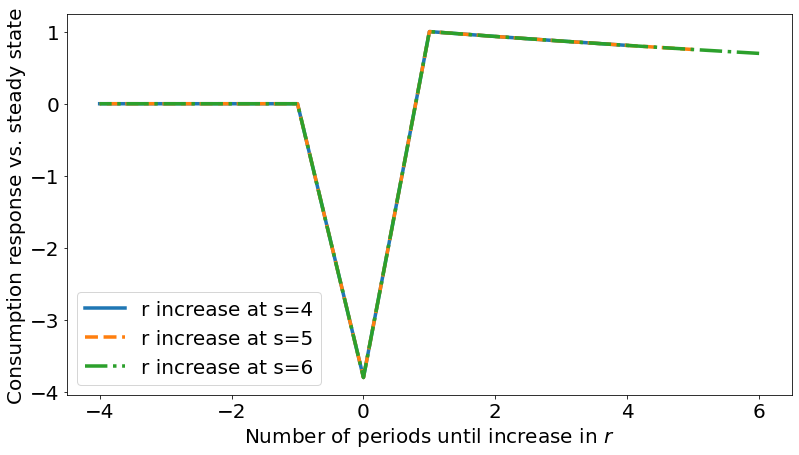

In [62]:
plt.plot(range(4, -5, -1), impulse_s4[:9, 3, 50], label='r increase at s=4')
plt.plot(range(5, -5, -1), impulse_s5[:10, 3, 50], '--', label='r increase at s=5')
plt.plot(range(6, -5, -1), impulse_s6[:11, 3, 50], '-.', label='r increase at s=6')
plt.xlabel(r'Number of periods until increase in $r$')
plt.ylabel('Consumption response vs. steady state')
plt.legend();

In [63]:
%%time
da = impulse_map(ss_ge['r'] + h*(np.arange(T) == T-1), 1)[1]['a'] - ss_ge['a']

CPU times: user 91.4 ms, sys: 6.51 ms, total: 97.9 ms
Wall time: 96.4 ms


In [64]:
%%time
J_alt = np.empty((T, T))
a_ss = np.broadcast_to(ss_ge['a'], da.shape)
for s in range(T):            # for each dr_s from s=0,...,T-1
    a = a_ss.copy()           # start with steady-state asset policy
    a[:s+1] += da[T-1-s:]     # shock at s impacts 'a' up through s, use response to shock at T-1 starting at T-1-s
    D = distribution_impulse(ss_ge, a, T)
    A = np.sum(a*D, axis=(1,2))
    J_alt[:, s] = (A - B - no_shock) / h

CPU times: user 12.8 s, sys: 489 ms, total: 13.3 s
Wall time: 13.3 s


In [65]:
a = a_ss.copy()
a[0] += da[T-1-10] # only shock is to asset policy at date 0 from anticipating s=10 then, nothing else
D = distribution_impulse(ss_ge, a, T)
A = np.sum(a*D, axis=(1,2))
anticipation_effect = (A - B - no_shock) / h

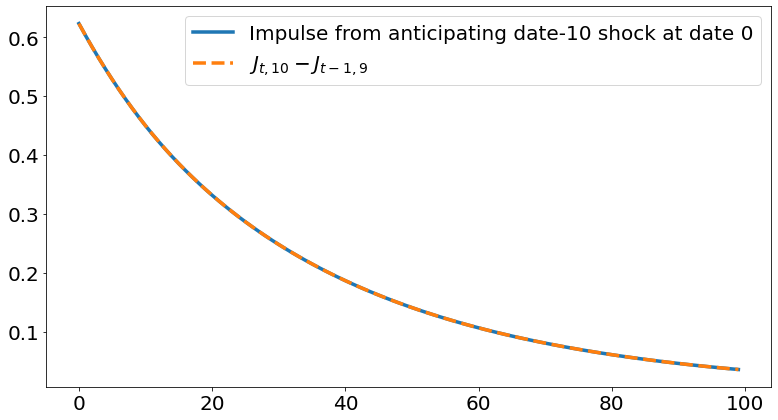

In [74]:
plt.plot(anticipation_effect[:100], label='Impulse from anticipating date-10 shock at date 0')
F = J.copy()
F[1:, 1:] -= J[:-1, :-1]
plt.plot(F[:100, 10], '--', label='$J_{t, 10} - J_{t-1, 9}$')
plt.legend();

In [67]:
%%time
F_alt = np.empty((T,T))
for s in range(T):
    # calculate impulse response to anticipation of date-s shock at date 0
    a = a_ss.copy()
    a[0] += da[T-1-s] 
    D = distribution_impulse(ss_ge, a, T)
    A = np.sum(a*D, axis=(1,2))
    F_alt[:, s] = (A - B - no_shock) / h
np.max(np.abs(F_alt - F))

CPU times: user 14.6 s, sys: 667 ms, total: 15.2 s
Wall time: 16.2 s


6.711999844810634e-05

In [68]:
def J_from_F(F):
    J = F.copy()
    for t in range(1, F.shape[0]):
        J[1:, t] += J[:-1, t-1]
    return J

In [77]:
Jff = J_from_F(F)
np.array_equal(Jff, J)

True

In [85]:
a_i_ge, a_pi_ge = get_lottery(ss_ge['a'], a_grid)
curlyE = expectation_vectors(ss_ge['a'], a_i_ge, a_pi_ge, T)

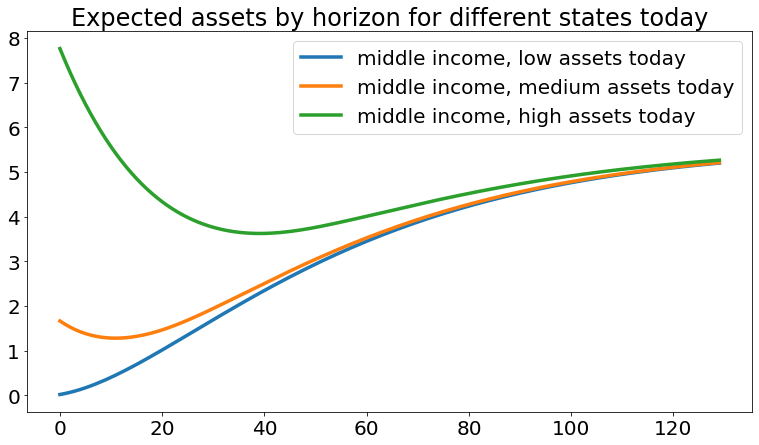

In [87]:
plt.plot(curlyE[:130, 3, 0], label='middle income, low assets today')
plt.plot(curlyE[:130, 3, 150], label='middle income, medium assets today')
plt.plot(curlyE[:130, 3, 250], label='middle income, high assets today')
plt.title('Expected assets by horizon for different states today')
plt.legend();

In [124]:
F = np.empty((T,T))
a_i_ge, a_pi_ge = get_lottery(ss_ge['a'], a_grid)
D1_noshock = forward_iteration(ss_ge['D'], Pi, a_i_ge, a_pi_ge)
for s in range(T):
    # F_(0,s): change in asset policy times steady-state incoming distribution
    F[0, s] = np.vdot(ss_ge['D'], da[T-1-s]) / h
    
    # change in D_1 from this change
    a_i_shocked, a_pi_shocked = get_lottery(ss_ge['a'] + da[T-1-s], ss_ge['a_grid'])
    dD1 = forward_iteration(ss_ge['D'], Pi, a_i_shocked, a_pi_shocked) - D1_noshock
    
    # use expectation vectors to project effect on aggregate
    F[1:, s] = (curlyE[:T-1].reshape(T-1, -1) @ dD1.ravel()) / h
    
J_alt = J_from_F(F)

In [128]:
J_alt[0:5,0:5]

array([[0.4850996 , 0.95378775, 0.90403595, 0.85945355, 0.818771  ],
       [0.55361279, 1.388761  , 1.81783126, 1.72845144, 1.64652775],
       [0.61068621, 1.41613472, 2.21487703, 2.60882446, 2.48525374],
       [0.65901768, 1.43677364, 2.20800914, 2.97403405, 3.33667655],
       [0.70016684, 1.45183635, 2.19728986, 2.93762715, 3.67424349]])